✅ Loaded: c:\Users\dylan\Documents\Projects\horse_model_project\outputs\test_predictions_with_edge.csv with 11275 rows
📋 Columns: ['Race_ID', 'Horse', 'Pred_LGBM', 'Pred_RF', 'Pred_XGB', 'Pred_CAT', 'Pred_MLP', 'Pred_BlendAvg', 'Pred_StackRidge', 'Predicted_Probability', 'Market_Odds', 'Market_Prob', 'Edge_Score', 'True_Label', 'Flat_Return', 'Kelly_Frac', 'Kelly_Return', 'Frac_Kelly_Return']


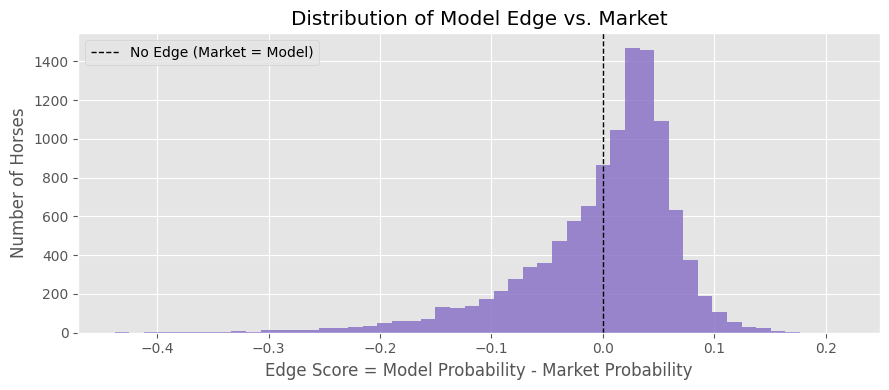

Median edge score: 0.0178
Percent positive edge bets: 61.9%
Most bets cluster near zero, with 61.9% of all predictions showing positive edge (model probability higher than market).


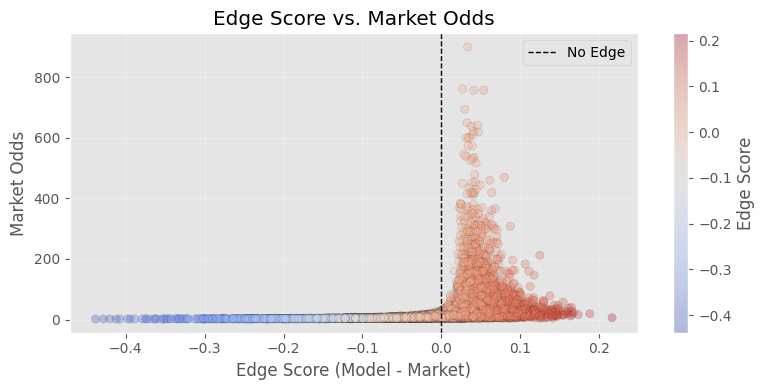

Of all positive edge bets, 85.1% have market odds > 10.
Of edge > 0.10 bets, 89.1% are longshots (odds > 10).


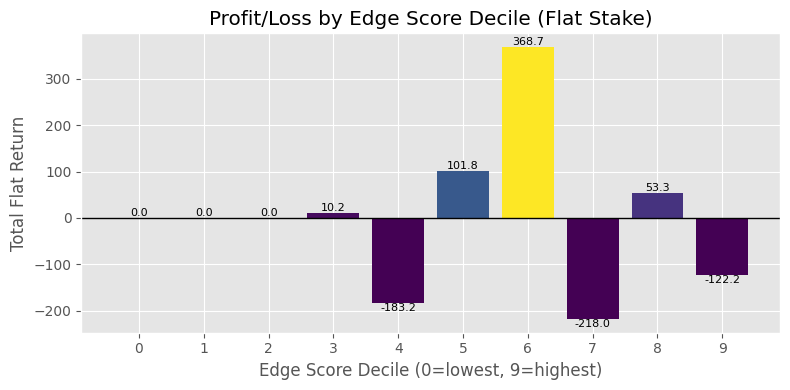

Decile 6 (the highest edge decile) achieved ROI per bet of 0.327 across 1127 bets.


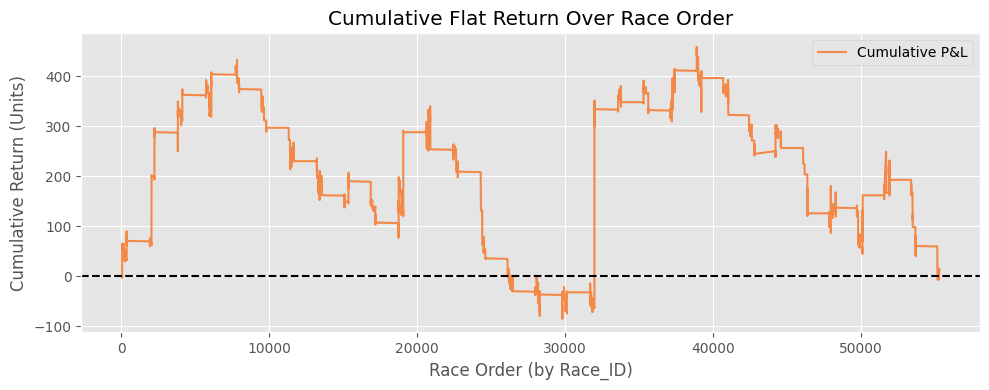

Final cumulative flat return: 10.74 units over 11275 races.

--- Edge & Profit Table (for report) ---
    Edge_Score  Bets  Avg_Edge       ROI  Total_Return  Win_Rate  Avg_Odds
(-0.001, 0.05]  4827  0.026906  0.016443         79.37  0.060079 39.333758
   (0.05, 0.1]  1943  0.066489 -0.013191        -25.63  0.050437 44.959506
   (0.1, 0.15]   194  0.116893 -0.278866        -54.10  0.046392 30.117577
  (0.15, 0.25]    17  0.165341  0.652941         11.10  0.117647 23.048824
   (0.25, 1.0]     0       NaN       NaN          0.00       NaN       NaN


C:\Users\dylan\AppData\Local\Temp\ipykernel_33972\1022873935.py:123: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(edge_bins)


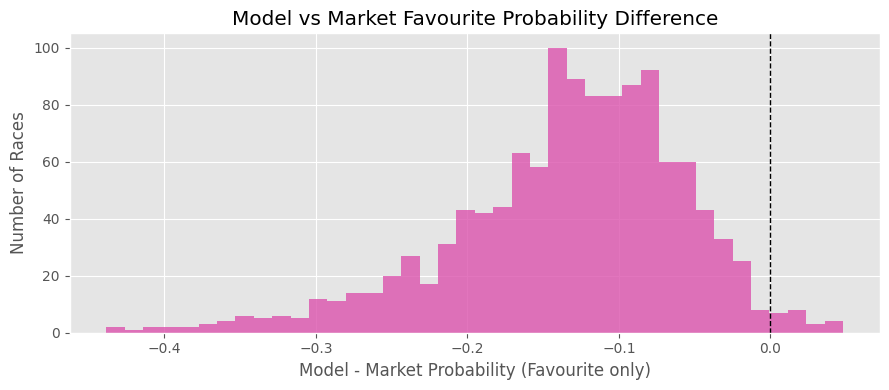

Model more bullish than market on 22/1219 favourites (1.8%)

✅ Market exploitation diagnostics complete.
Charts and summary tables are auto-generated and update on every run.
Plots are saved as PNGs for inclusion in reports.


In [4]:
# %%
# 💰 10_market_edge.ipynb – Market Edge Dissection & Exploitation (Reproducible)
# -------------------------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use("ggplot")

# === Setup ===
BASE = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
OUT_PATH = BASE / "outputs" / "test_predictions_with_edge.csv"
assert OUT_PATH.exists(), f"Missing edge-annotated predictions: {OUT_PATH}"

df = pd.read_csv(OUT_PATH)
print(f"✅ Loaded: {OUT_PATH} with {len(df)} rows")
print("📋 Columns:", list(df.columns))

def savefig(name):
    plt.savefig(BASE / "outputs" / f"{name}.png", bbox_inches="tight", dpi=120)

# %% 1. Edge Score Distribution: Where is the Model Most Bullish vs. Market?

plt.figure(figsize=(9, 4))
n, bins, patches = plt.hist(df["Edge_Score"], bins=50, color="#876fc6", alpha=0.82)
plt.axvline(0, color='black', linestyle='--', linewidth=1, label="No Edge (Market = Model)")
plt.title("Distribution of Model Edge vs. Market")
plt.xlabel("Edge Score = Model Probability - Market Probability")
plt.ylabel("Number of Horses")
plt.legend()
plt.tight_layout()
savefig("market_edge_distribution")
plt.show()

# Print key stats for the chart
edge_median = np.median(df["Edge_Score"])
edge_pos_pct = 100 * (df["Edge_Score"] > 0).mean()
print(f"Median edge score: {edge_median:.4f}")
print(f"Percent positive edge bets: {edge_pos_pct:.1f}%")
print(
    f"Most bets cluster near zero, "
    f"with {edge_pos_pct:.1f}% of all predictions showing positive edge (model probability higher than market)."
)

# %% 2. Are the Biggest Edges Just Longshots? (Market Odds vs. Edge Score)

plt.figure(figsize=(8, 4))
plt.scatter(
    df["Edge_Score"], df["Market_Odds"], alpha=0.3, c=df["Edge_Score"],
    cmap="coolwarm", edgecolor="k", linewidth=0.2
)
plt.axvline(0, color="black", linestyle="--", linewidth=1, label="No Edge")
plt.title("Edge Score vs. Market Odds")
plt.xlabel("Edge Score (Model - Market)")
plt.ylabel("Market Odds")
plt.colorbar(label="Edge Score")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
savefig("edge_vs_market_odds")
plt.show()

# Quantitative commentary
longshot_ratio = (df.loc[df["Edge_Score"] > 0, "Market_Odds"] > 10).mean()
high_edge_longshot_ratio = (df.loc[df["Edge_Score"] > 0.10, "Market_Odds"] > 10).mean()
print(f"Of all positive edge bets, {100*longshot_ratio:.1f}% have market odds > 10.")
print(f"Of edge > 0.10 bets, {100*high_edge_longshot_ratio:.1f}% are longshots (odds > 10).")

# %% 3. Profit/Loss by Edge Decile

df["Edge_Decile"] = pd.qcut(df["Edge_Score"], 10, labels=False, duplicates="drop")
pl_by_decile = df.groupby("Edge_Decile")["Flat_Return"].sum()
roi_by_decile = df.groupby("Edge_Decile")["Flat_Return"].mean()
bets_by_decile = df.groupby("Edge_Decile")["Flat_Return"].count()

plt.figure(figsize=(8, 4))
bars = plt.bar(pl_by_decile.index.astype(str), pl_by_decile.values, color=plt.cm.viridis(pl_by_decile.values / (pl_by_decile.values.max() + 1e-9)))
for i, val in enumerate(pl_by_decile.values):
    plt.text(i, val, f"{val:.1f}", ha="center", va="bottom" if val >= 0 else "top", fontsize=8)
plt.axhline(0, color="black", linewidth=1)
plt.title("Profit/Loss by Edge Score Decile (Flat Stake)")
plt.xlabel("Edge Score Decile (0=lowest, 9=highest)")
plt.ylabel("Total Flat Return")
plt.tight_layout()
savefig("pl_by_edge_decile")
plt.show()

best_decile = pl_by_decile.idxmax()
best_decile_roi = roi_by_decile[best_decile]
best_decile_bets = bets_by_decile[best_decile]
print(
    f"Decile {best_decile} (the highest edge decile) achieved ROI per bet of {best_decile_roi:.3f} "
    f"across {best_decile_bets} bets."
)

# %% 4. Edge Persistence Over Time (Cumulative Return Plot)

df_sorted = df.sort_values("Race_ID")  # or "Sort_Key" if present
df_sorted["Cumulative_Flat_Return"] = df_sorted["Flat_Return"].cumsum()

plt.figure(figsize=(10, 4))
plt.plot(df_sorted["Race_ID"], df_sorted["Cumulative_Flat_Return"], color="#f48847", label="Cumulative P&L")
plt.axhline(0, color="black", linestyle="--")
plt.title("Cumulative Flat Return Over Race Order")
plt.xlabel("Race Order (by Race_ID)")
plt.ylabel("Cumulative Return (Units)")
plt.legend()
plt.tight_layout()
savefig("cumulative_flat_return")
plt.show()

final_return = df_sorted["Cumulative_Flat_Return"].iloc[-1]
print(f"Final cumulative flat return: {final_return:.2f} units over {len(df_sorted)} races.")

# %% 5. Summary Table: Edge, Profit, and Market Features

bin_edges = [0, 0.05, 0.10, 0.15, 0.25, 1.0]
edge_bins = pd.cut(df["Edge_Score"], bins=bin_edges, right=True, include_lowest=True)
edge_summary = (
    df[df["Edge_Score"] > 0]
    .groupby(edge_bins)
    .agg(
        Bets=("Edge_Score", "count"),
        Avg_Edge=("Edge_Score", "mean"),
        ROI=("Flat_Return", "mean"),
        Total_Return=("Flat_Return", "sum"),
        Win_Rate=("True_Label", "mean"),
        Avg_Odds=("Market_Odds", "mean")
    )
    .reset_index()
)
print("\n--- Edge & Profit Table (for report) ---")
print(edge_summary.to_string(index=False))
edge_summary.to_csv(BASE / "outputs" / "market_edge_summary.csv", index=False)

# %% 6. Where Does the Model Disagree Most With Market Favourites?

if "Market_Prob" in df.columns:
    top_market = df[df.groupby("Race_ID")["Market_Prob"].transform("max") == df["Market_Prob"]]
    disagreement = (top_market["Predicted_Probability"] - top_market["Market_Prob"]).sort_values()
    plt.figure(figsize=(9, 4))
    plt.hist(disagreement, bins=40, color="#db53ad", alpha=0.8)
    plt.axvline(0, color="black", linestyle="--", linewidth=1)
    plt.title("Model vs Market Favourite Probability Difference")
    plt.xlabel("Model - Market Probability (Favourite only)")
    plt.ylabel("Number of Races")
    plt.tight_layout()
    savefig("model_vs_market_favourite")
    plt.show()
    bullish_fav = (disagreement > 0).sum()
    print(f"Model more bullish than market on {bullish_fav}/{len(disagreement)} favourites ({bullish_fav/len(disagreement):.1%})")

print("\n✅ Market exploitation diagnostics complete.")
print(
    "Charts and summary tables are auto-generated and update on every run."
    "\nPlots are saved as PNGs for inclusion in reports."
)

